# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from PIL import Image

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


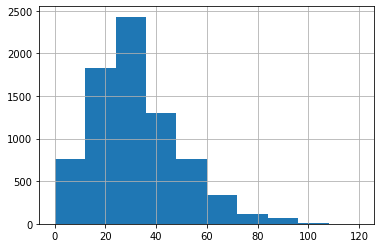

In [ ]:
labels['real_age'].hist(range=(0,120))
plt.show()

In [ ]:
display(labels.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


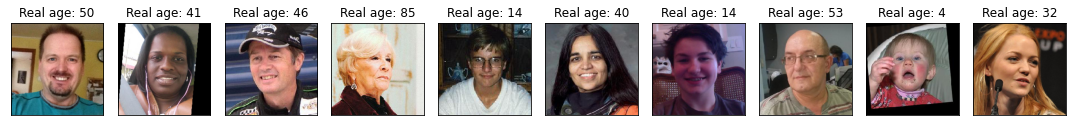

In [ ]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(15,15))
for i in range(10):
    fig.add_subplot(1,10, i +1)
    plt.imshow(features[i])
    plt.title('Real age: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Обучение модели


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, AvgPool2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
 
 
def load_train(path):
    data_classes=pd.read_csv(path+'labels.csv')
    
    train_datagen = ImageDataGenerator(rescale = 1/255,
                                       horizontal_flip = True,
                                       brightness_range = (0.8,1.0),
                                       validation_split = 0.25)            
 
 
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=data_classes,
                                           directory =path+'final_files/',
                                           x_col='file_name',
                                           y_col ='real_age',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='raw',
                                           subset='training',                
                                           seed=12345)
    return train_datagen_flow
 
def load_test(path):
    data_classes=pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=data_classes,
                                           directory =path+'final_files/',
                                           x_col='file_name',
                                           y_col ='real_age',
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='raw',
                                           subset ='validation',
                                           seed=12345)
    return test_datagen_flow
 
 
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    #backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=40,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 
 

```

Задача: построить модель, которая определит возраст покупателей.
В нашем распоряжении датасет из 7591 объекта.

Была создана и обучена модель на основе ResNet50. При learning_rate=0.0001, Dense(units =1), epochs=40, модель показала результат mae (средняя сумма абсолютной разницы между фактическим и прогнозируемым значением) = 5.4.

Можно сделать вывод, что модель справляется с поставленными задачами.